# Essay Writer

## Defining the Agent State and Prompts

In [1]:
%pip install -q openai langchain langchain-openai langchain-community langgraph pydantic langsmith

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [3]:
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

In [22]:
from typing import TypedDict, List

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [5]:
# Defining the planning prompt 
PLAN_PROMPT = '''You are an expert writer tasked with writing a high level outline of an essay.
Write such an outline for the user provided topic.
Give an outline of the essay along with any relevant notes or instructions for the sections.'''

# defining the prompt that will be used by the agent that's doing research after the planning step
# given a plan, it will generate some queries and pass them to Tavily
RESEARCH_PLAN_PROMPT = '''You are a researcher charged with providing information that can be used when writing the following essay.
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.'''

# Defining the writer prompt
WRITER_PROMPT = '''You are an essay assistant tasked with writing excellent 5-paragraph essays.
Generate the best essay possible for the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Utilize all the information below as needed: 

------

{content}'''

# Defining the reflection prompt
REFLECTION_PROMPT = '''You are a teacher grading an essay submission.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for length, depth, style, etc.'''

# Defining the research critique prompt
RESEARCH_CRITIQUE_PROMPT = ''''You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below).
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.'''

In [6]:
from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [7]:
# Importing and instantiating a tavily client
from tavily import TavilyClient
import os

tavily = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])

In [8]:
# Creating the planning node
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [9]:
# Creating the reseach_plan_node
# It generates research queries based on a given task and retrieves relevant content using those queries
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    # content = state['content'] or [] # fix - change to this:
    content = state.get('content', [])
    
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}


In [10]:
# Creating the generation node
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    
    response = model.invoke(messages)
     
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }

In [11]:
# Creating the reflection node
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}


In [12]:
# Creating the research critique node
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {'content': content}

## Defining the Conditional Edge

In [13]:
# Defining the conditional edge
def should_continue(state):
    if state['revision_number'] > state['max_revisions']:
        return END
    return 'reflect'

## Defining the Graph

In [14]:
builder = StateGraph(AgentState)

# Adding nodes to the graph
builder.add_node('planner', plan_node)
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)
builder.add_node('research_plan', research_plan_node)
builder.add_node('research_critique', research_critique_node)

# Setting the entry point of the state graph
builder.set_entry_point('planner')

# Adding the conditional edge
builder.add_conditional_edges(
    'generate', 
    should_continue, 
    {END: END, 'reflect': 'reflect'}
)

# Adding regular edges
builder.add_edge('planner', 'research_plan')
builder.add_edge('research_plan', 'generate')

builder.add_edge('reflect', 'research_critique')
builder.add_edge('research_critique', 'generate')

In [15]:
%pip install -q langgraph-checkpoint-sqlite

Note: you may need to restart the kernel to use updated packages.


In [16]:
from langgraph.checkpoint.sqlite import SqliteSaver
# fix - import this
from langgraph.checkpoint.memory import MemorySaver

memory = SqliteSaver.from_conn_string(':memory:')

# graph = builder.compile(checkpointer=memory) # fix - change to this:
graph = builder.compile(checkpointer=MemorySaver())

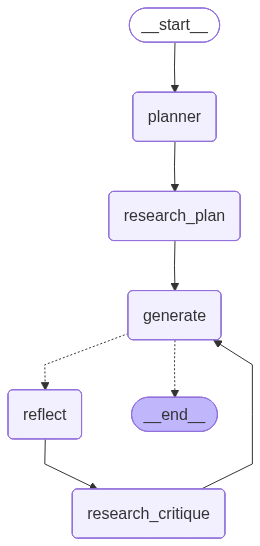

In [17]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Running the Agentic App

In [20]:
thread = {'configurable': {'thread_id': '1'}}
task = 'Write an essay about Integration of AI in software development.'

prompt = {
    'task': task,
    'max_revisions': 2,
    'revision_number': 1,
}

events = graph.stream(prompt, thread)
for e in events:
    print(e)
    print('-' * 100)

{'planner': {'plan': '**Outline for Essay: Integration of AI in Software Development**\n\n**I. Introduction**\n   A. Definition of AI and its relevance in modern technology\n   B. Overview of software development and its traditional processes\n   C. Thesis statement: The integration of AI in software development enhances efficiency, improves code quality, and fosters innovation, ultimately transforming the landscape of the industry.\n\n**II. Historical Context of AI in Software Development**\n   A. Early applications of AI in programming (e.g., expert systems)\n   B. Evolution of AI technologies (machine learning, natural language processing)\n   C. Milestones in AI integration within software development practices\n\n**III. Benefits of AI Integration in Software Development**\n   A. Increased Efficiency\n      1. Automation of repetitive tasks (e.g., code generation, testing)\n      2. Faster development cycles through AI-driven tools\n   B. Improved Code Quality\n      1. AI-assisted

In [21]:
print(e['generate']['draft'])

**Integration of AI in Software Development**

**I. Introduction**

Artificial Intelligence (AI) has emerged as a transformative force in modern technology, reshaping industries and redefining the way we approach complex problems. In the realm of software development, where traditional processes often involve meticulous coding, testing, and debugging, the integration of AI offers a promising avenue for enhancing efficiency and innovation. This essay explores the historical context of AI in software development, the benefits it brings, the tools and technologies that facilitate its integration, the challenges that arise, and the future trends that may shape the industry. Ultimately, the integration of AI in software development enhances efficiency, improves code quality, and fosters innovation, transforming the landscape of the industry.

**II. Historical Context of AI in Software Development**

The journey of AI in software development began with early applications such as expert syste